In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 503MB/s] 


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [27]:
import random

In [5]:
# Path to the extracted dataset
base_dir = "./animal-faces/afhq"

# Lists to store image paths and labels
image_paths = []
labels = []

# Loop through the train, val, and test directories
for split in os.listdir(base_dir):
    split_dir = os.path.join(base_dir, split)
    
    # Loop through each label directory
    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)
        
        # Loop through each image file
        for image_file in os.listdir(label_dir):
            image_paths.append(os.path.join(label_dir, image_file))
            labels.append(label)

# Create a DataFrame to organize the data
data_df = pd.DataFrame(list(zip(image_paths, labels)), columns=["image_paths", "labels"])

# Display the first 5 rows
print(data_df.head())
print(f"\nTotal Images: {len(data_df)}")

                                         image_paths labels
0  ./animal-faces/afhq\train\cat\flickr_cat_00000...    cat
1  ./animal-faces/afhq\train\cat\flickr_cat_00000...    cat
2  ./animal-faces/afhq\train\cat\flickr_cat_00000...    cat
3  ./animal-faces/afhq\train\cat\flickr_cat_00000...    cat
4  ./animal-faces/afhq\train\cat\flickr_cat_00000...    cat

Total Images: 16130


In [6]:

train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [7]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [9]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

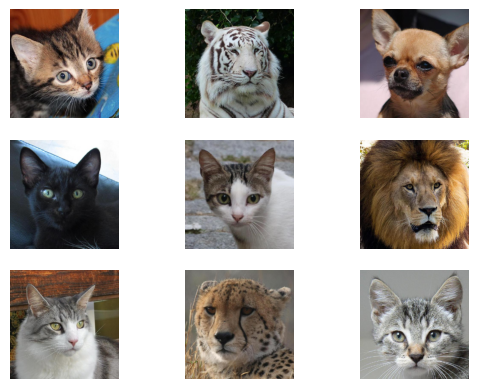

In [10]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [18]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device

In [21]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [23]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device).long()  # Convert to LongTensor
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device).long()  # Convert to LongTensor
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 1.924 Train Accuracy 77.0171
              Validation Loss: 0.2141 Validation Accuracy: 90.5785
Epoch 2/10, Train Loss: 0.888 Train Accuracy 90.9397
              Validation Loss: 0.2037 Validation Accuracy: 90.4545
Epoch 3/10, Train Loss: 0.6282 Train Accuracy 93.6941
              Validation Loss: 0.1293 Validation Accuracy: 94.5868
Epoch 4/10, Train Loss: 0.4671 Train Accuracy 95.2263
              Validation Loss: 0.1212 Validation Accuracy: 94.5041
Epoch 5/10, Train Loss: 0.3498 Train Accuracy 96.3688
              Validation Loss: 0.115 Validation Accuracy: 94.8347
Epoch 6/10, Train Loss: 0.2739 Train Accuracy 97.0773
              Validation Loss: 0.0941 Validation Accuracy: 95.5785
Epoch 7/10, Train Loss: 0.2426 Train Accuracy 97.5556
              Validation Loss: 0.1059 Validation Accuracy: 95.2066
Epoch 8/10, Train Loss: 0.1746 Train Accuracy 98.1844
              Validation Loss: 0.1178 Validation Accuracy: 95.124
Epoch 9/10, Train Loss: 0.1322 Train

In [24]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device).long()  # Convert to LongTensor

    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")
     

Accuracy Score is: 96.2795 and Loss is 0.009


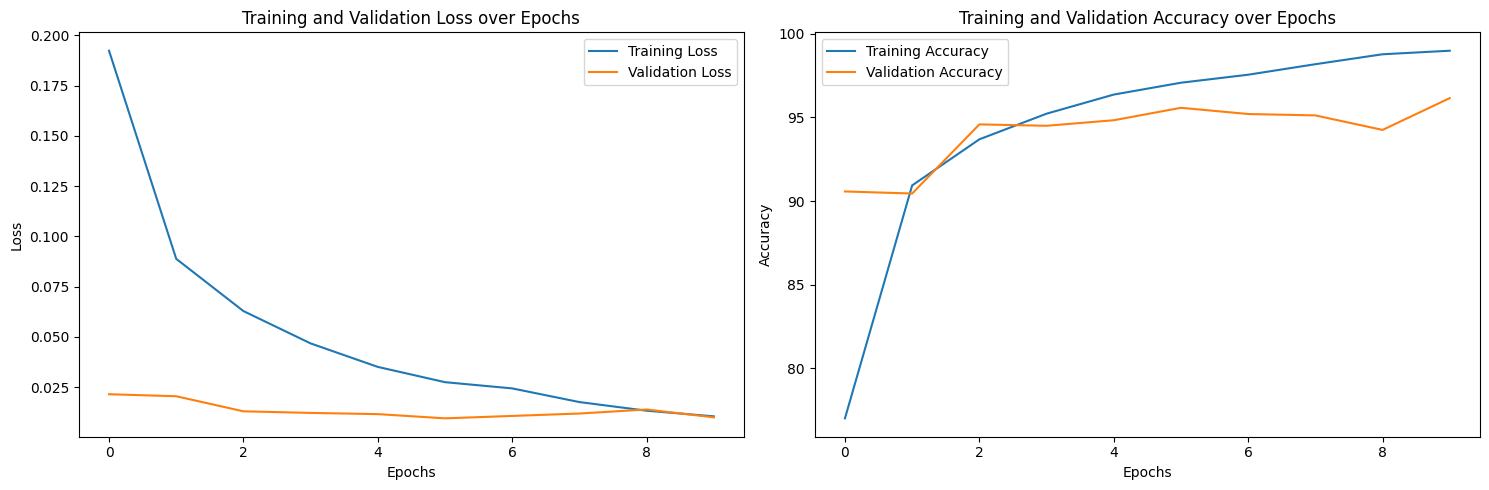

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

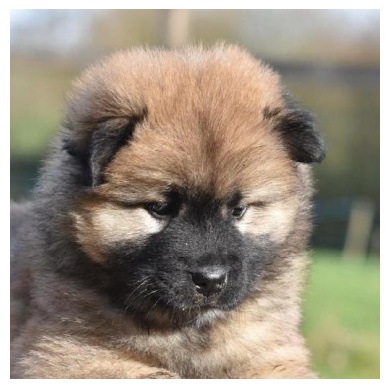


Prediction:

dog


In [36]:
# Directory containing the images
base_dir = "./animal-faces/afhq/train"

def predict_image(image_path):
    # 1- Read Image
    image = Image.open(image_path).convert('RGB')
    
    # 2- Transform using the defined transform object
    image = transform(image).to(device)
    
    # 3- Predict through the model
    output = model(image.unsqueeze(0))
    output = torch.argmax(output, axis=1).item()
    
    # 4- Inverse transform by label encoder
    predicted_label = label_encoder.inverse_transform([output])[0]
    
    return predicted_label

# Select a random category
random_category = random.choice(os.listdir(base_dir))

# Get all valid image files in the selected category
category_path = os.path.join(base_dir, random_category)
image_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select a random image
random_image_path = os.path.join(category_path, random.choice(image_files))

# Display the random image
image = Image.open(random_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Predict the label
print("\nPrediction:\n")
prediction = predict_image(random_image_path)
print(prediction)